In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, BatchNormalization, TimeDistributed, Dense
from keras.layers import Flatten
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/__init__.py
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()

In [3]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

dataset_df = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


In [4]:
labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [5]:
# Categorizing Features on the Type
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [6]:
def feature_engineer(dataset_df):
    dfs = []
    for c in CATS:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in EVENTS: 
        dataset_df[c] = (dataset_df.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    dataset_df = dataset_df.drop(EVENTS,axis=1)
        
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [7]:
dataset_df = feature_engineer(dataset_df)
print("Dataset shape is {}".format(dataset_df.shape))

Dataset shape is (70686, 32)


In [8]:
num_features = len(dataset_df.columns) - 1  # Subtract 1 for the target variable
print("Number of features:", num_features)

Number of features: 31


In [9]:
# Print feature list with index starting at 1
feature_list = dataset_df.columns[:-1]  # Exclude the last column (target variable)
for index, feature in enumerate(feature_list, start=1):
    print(f"{index}. {feature}")

1. level_group
2. event_name_nunique
3. name_nunique
4. fqid_nunique
5. room_fqid_nunique
6. text_fqid_nunique
7. elapsed_time_mean
8. level_mean
9. page_mean
10. room_coor_x_mean
11. room_coor_y_mean
12. screen_coor_x_mean
13. screen_coor_y_mean
14. hover_duration_mean
15. elapsed_time_std
16. level_std
17. page_std
18. room_coor_x_std
19. room_coor_y_std
20. screen_coor_x_std
21. screen_coor_y_std
22. hover_duration_std
23. navigate_click_sum
24. person_click_sum
25. cutscene_click_sum
26. object_click_sum
27. map_hover_sum
28. notification_click_sum
29. map_click_sum
30. observation_click_sum
31. checkpoint_sum


In [10]:
FEATURES = [c for c in dataset_df.columns if c != 'level_group']

In [11]:
# Splitting DataSet into Train and Valid
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

# Generating Split DataSet
train_x, test_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in validation.".format(
    len(train_x), len(test_x)))

56547 examples in training, 14139 examples in validation.


In [12]:
# Splitting the Data into Train and Test
train_x, valid_x = split_dataset(train_x)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

45237 examples in training, 11310 examples in testing.


In [13]:
# Function to Split DataSet into Parts
def save_to_multiple_csv_files(data, name_prefix, question, header=None, n_parts=5):
    # Setting the Directory
    # Creating Directory for Each Question
    game_prediction_dir = os.path.join("/kaggle/working/datasets_"+str(question), "student_performance_data")
    os.makedirs(game_prediction_dir, exist_ok=True)
    path_format = os.path.join(game_prediction_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [14]:
# Generating CSV files for Each Question and Saving them
train_file_paths_for_questions = []
valid_file_paths_for_questions = []
test_file_paths_for_questions = []

header_cols = train_x.columns
header = ",".join(header_cols)

for q_no in range(1,19):
    
    # Selecting the Group based on Question Number
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("##### Generating CSV for q_no", q_no, "grp", grp)
    
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values
    test_df = test_x.loc[test_x.level_group == grp]
    test_users = test_df.index.values
    
    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]
    test_labels = labels.loc[labels.q==q_no].set_index('session').loc[test_users]
    
     # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]
    test_df["correct"] = test_labels["correct"]
    
    # Dropping Column Level Group
    train_ds_data = train_df.drop(columns=['level_group'])
    valid_ds_data = valid_df.drop(columns=['level_group'])
    test_ds_data = test_df.drop(columns=['level_group'])
    train_ds_data.reset_index()
    valid_ds_data.reset_index()
    test_ds_data.reset_index()
    
    # Calling function to generate CSVs
    train_filepaths = save_to_multiple_csv_files(train_ds_data.to_numpy(), "train", "q_no_"+str(q_no), header, n_parts=5)
    valid_filepaths = save_to_multiple_csv_files(valid_ds_data.to_numpy(), "valid", "q_no_"+str(q_no), header, n_parts=5)
    test_filepaths = save_to_multiple_csv_files(test_ds_data.to_numpy(), "test", "q_no_"+str(q_no), header, n_parts=5)
    
    # Saving File Paths
    train_file_paths_for_questions.append(train_filepaths)
    valid_file_paths_for_questions.append(valid_filepaths)
    test_file_paths_for_questions.append(test_filepaths)

##### Generating CSV for q_no 1 grp 0-4
##### Generating CSV for q_no 2 grp 0-4
##### Generating CSV for q_no 3 grp 0-4
##### Generating CSV for q_no 4 grp 5-12
##### Generating CSV for q_no 5 grp 5-12
##### Generating CSV for q_no 6 grp 5-12
##### Generating CSV for q_no 7 grp 5-12
##### Generating CSV for q_no 8 grp 5-12
##### Generating CSV for q_no 9 grp 5-12
##### Generating CSV for q_no 10 grp 5-12
##### Generating CSV for q_no 11 grp 5-12
##### Generating CSV for q_no 12 grp 5-12
##### Generating CSV for q_no 13 grp 5-12
##### Generating CSV for q_no 14 grp 13-22
##### Generating CSV for q_no 15 grp 13-22
##### Generating CSV for q_no 16 grp 13-22
##### Generating CSV for q_no 17 grp 13-22
##### Generating CSV for q_no 18 grp 13-22


In [15]:
# Pre Process Function
n_inputs = 31
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    X = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return X, y

In [16]:
# CSV Reader for Train
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,  # number of files or filepaths
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # skip the header row via map_func
        cycle_length=n_readers, # 'interleave' pull cycle_length(=n_readers) file paths(1 by 1) from the 'dataset'
        num_parallel_calls=n_read_threads) 
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    
    return dataset.prefetch(1)

In [17]:
# Using the Saved CSV Loading the Data and saving them to a List
train_set_list = []
valid_set_list = []
test_set_list = []

for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("##### Loading CSV for q_no", q_no, "grp", grp)
    
    train_set = csv_reader_dataset(train_file_paths_for_questions[q_no - 1])
    valid_set = csv_reader_dataset(valid_file_paths_for_questions[q_no - 1]) 
    test_set = csv_reader_dataset(test_file_paths_for_questions[q_no - 1])   
    
    train_set_list.append(train_set)
    valid_set_list.append(valid_set)
    test_set_list.append(test_set)

##### Loading CSV for q_no 1 grp 0-4
##### Loading CSV for q_no 2 grp 0-4
##### Loading CSV for q_no 3 grp 0-4
##### Loading CSV for q_no 4 grp 5-12
##### Loading CSV for q_no 5 grp 5-12
##### Loading CSV for q_no 6 grp 5-12
##### Loading CSV for q_no 7 grp 5-12
##### Loading CSV for q_no 8 grp 5-12
##### Loading CSV for q_no 9 grp 5-12
##### Loading CSV for q_no 10 grp 5-12
##### Loading CSV for q_no 11 grp 5-12
##### Loading CSV for q_no 12 grp 5-12
##### Loading CSV for q_no 13 grp 5-12
##### Loading CSV for q_no 14 grp 13-22
##### Loading CSV for q_no 15 grp 13-22
##### Loading CSV for q_no 16 grp 13-22
##### Loading CSV for q_no 17 grp 13-22
##### Loading CSV for q_no 18 grp 13-22


In [18]:
# Parameters
k = 5  # Number of folds
n_epochs = 10 # Needs to be raised 
batch_size = 32

# Initialize lists for storing results
test_loss_and_accuracy_list = []
history_models = []
models = {}
f1_score_list = []

# Initialize lists for storing all predictions and true labels
all_predictions = []
all_true_labels = []

# Adjusted function to handle ragged sequences
def dataset_to_numpy(ds, padding='post', maxlen=None):
    X, y = [], []
    for features, label in ds:
        X.append(features.numpy())
        y.append(label.numpy())
    # Pad sequences if they are ragged
    X_padded = pad_sequences(X, padding=padding, maxlen=maxlen, dtype='float32')
    y_padded = pad_sequences(y, padding=padding, maxlen=maxlen, dtype='float32')
    return X_padded, y_padded

# KFold configuration
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for q_no in range(1, 19):
    # Select level group for the question based on the q_no.
    if q_no <= 3:
        grp = '0-4'
    elif q_no <= 13:
        grp = '5-12'
    else:
        grp = '13-22'
    print("##### Training for q_no", q_no, "grp", grp)
    
    maxlen = 100  # Assuming 100 time steps is sufficient

    # Convert TensorFlow datasets to NumPy arrays with padding
    X_train, y_train = dataset_to_numpy(train_set_list[q_no - 1], maxlen=maxlen)
    X_valid, y_valid = dataset_to_numpy(valid_set_list[q_no - 1], maxlen=maxlen)
    X_test, y_test = dataset_to_numpy(test_set_list[q_no - 1], maxlen=maxlen)

    
    # Combine training and validation data for k-fold
    X_full = np.concatenate([X_train, X_valid], axis=0)
    y_full = np.concatenate([y_train, y_valid], axis=0)

    fold_no = 1
    for train_index, val_index in kf.split(X_full):
        print(f'Training fold {fold_no} for question number {q_no}')
        X_train_fold, X_val_fold = X_full[train_index], X_full[val_index]
        y_train_fold, y_val_fold = y_full[train_index], y_full[val_index]

        # Define the model
        model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(100, 31)),
        Dropout(0.2),
        BatchNormalization(),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        BatchNormalization(),
        TimeDistributed(Dense(1, activation='sigmoid'))])


        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold, epochs=n_epochs, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

        # Save the model and its history
        models[f'{grp}_{q_no}_fold{fold_no}'] = model
        history_models.append(history)

        fold_no += 1

    # Evaluate on the test set
    results = model.evaluate(X_test, y_test)
    test_loss_and_accuracy_list.append(results)

    # Calculate and store F1 score
    predictions = model.predict(X_test).round().astype(int).flatten()
    f1_score_value = f1_score(y_test.flatten(), predictions, average='weighted')
    f1_score_list.append(f1_score_value)

    # Aggregate predictions and true labels
    all_predictions.extend(predictions)
    all_true_labels.extend(y_test.flatten())

# Compute confusion matrix for all questions combined
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

##### Training for q_no 1 grp 0-4
Training fold 1 for question number 1
Epoch 1/10
15/15 [==============================] - 18s 150ms/step - loss: 0.5250 - accuracy: 0.8456 - val_loss: 0.5630 - val_accuracy: 0.9088
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 0.4011 - accuracy: 0.9019 - val_loss: 0.4738 - val_accuracy: 0.9188
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 0.3582 - accuracy: 0.9073 - val_loss: 0.4050 - val_accuracy: 0.9188
Epoch 4/10
15/15 [==============================] - 0s 24ms/step - loss: 0.3279 - accuracy: 0.9083 - val_loss: 0.3611 - val_accuracy: 0.9153
Epoch 5/10
15/15 [==============================] - 0s 24ms/step - loss: 0.3024 - accuracy: 0.9084 - val_loss: 0.3277 - val_accuracy: 0.9102
Training fold 2 for question number 1
Epoch 1/10
15/15 [==============================] - 10s 141ms/step - loss: 0.4477 - accuracy: 0.8942 - val_loss: 0.5750 - val_accuracy: 0.8966
Epoch 2/10
15/15 [======================

In [19]:
average_f1_score = np.mean(f1_score_list)
print("Average F1 Score:", average_f1_score)

Average F1 Score: 0.908821573473863


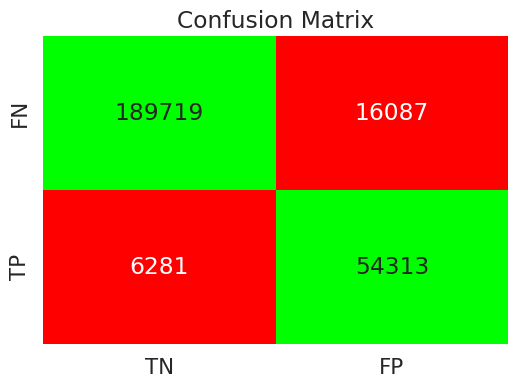

In [20]:
import seaborn as sns
# Compute confusion matrix for all questions combined
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
colors = ["#FF0000", "#00FF00", "#FF0000", "#00FF00"]  # red, green, red, green
cmap = sns.color_palette(colors)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.4)  # Adjust font size
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=cmap, cbar=False,
            xticklabels=['TN', 'FP'], yticklabels=['FN', 'TP'])
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Create a DataFrame for the scores
scores_df = pd.DataFrame({
    "F1 Score": f1_score_list,
    "Test Loss": [result[0] for result in test_loss_and_accuracy_list],
    "Test Accuracy": [result[1] for result in test_loss_and_accuracy_list]
}, index=range(1, 19))  # Set the index to "Question Number"

# Display the DataFrame
print(scores_df)

    F1 Score  Test Loss  Test Accuracy
1   0.918810   0.462134       0.914730
2   0.992256   0.113026       0.992230
3   0.979517   0.232117       0.979324
4   0.936029   0.424883       0.933716
5   0.872007   0.615474       0.858446
6   0.934597   0.474025       0.932162
7   0.922739   0.441859       0.919122
8   0.891686   0.463288       0.883176
9   0.926336   0.493252       0.923108
10  0.762199   0.398338       0.836622
11  0.896297   0.586325       0.888716
12  0.959476   0.399724       0.958649
13  0.866532   0.504336       0.909595
14  0.918151   0.519266       0.913987
15  0.772675   0.508960       0.844054
16  0.918705   0.413055       0.915338
17  0.906078   0.521001       0.901081
18  0.984699   0.176558       0.984595


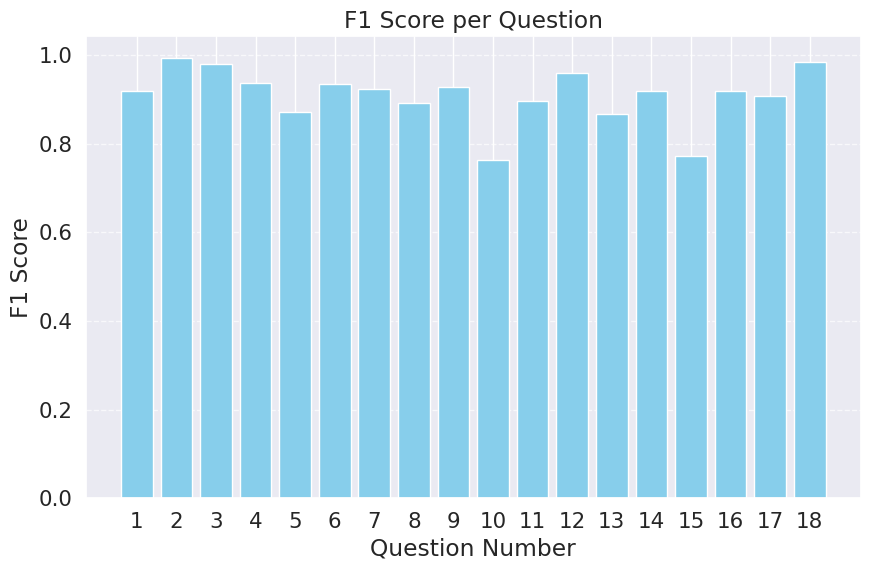

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 19), f1_score_list, color='skyblue')
plt.xlabel('Question Number')
plt.ylabel('F1 Score')
plt.title('F1 Score per Question')
plt.xticks(range(1, 19))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()